In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go 

import torch 
from torch import nn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from typing import Optional,Callable

In [10]:
class Data:

  def __init__(self,X1:torch.Tensor,
               y :torch.Tensor,
               X2:Optional[torch.Tensor]= None,
               bias:Optional[torch.Tensor]= None,
               n_samples = 20):
    
    self.X1 = torch.tensor(X1).flatten()
    self.y  = torch.tensor(y).flatten()
    self.X2 = torch.tensor(X2) if X2 is not None else None
    self.bias = torch.tensor(bias) if bias is not None else None
    self.n_samples = n_samples


    self.ONE_FEATURE  = (self.X2 is None) and (self.bias is None)
    self.TWO_FEATURES = (self.X2 is not None) and (self.bias is None)
    self.BIAS = (self.X2 is None) and (self.bias is not None)

#----------------------------------------------------------------------------------------------------------------PLOT DATA------------METHOD 1--------
  def plot_data(self):
#---------------------------ONE FEATURES--------------------
    if self.ONE_FEATURE:
      plot = go.Scatter(
        x = self.X1,
        y = self.y,
        mode = 'markers',
        name = 'Data')
      
      layout = go.Layout(
        title='Single Feature Regression Plot',
        xaxis=dict(title='X1',zeroline = True,zerolinewidth = 2,zerolinecolor = 'rgba(205, 200, 193, 0.7)'),
        yaxis=dict(title='Y',zeroline = True,zerolinewidth = 2,zerolinecolor = 'rgba(205, 200, 193, 0.7)') ,
        hovermode='closest')
      

  #-----------TWO FEATURES--------
    if self.TWO_FEATURES:
      plot = go.Scatter3d(
        x = self.X1,
        y = self.X2,
        z = self.y,
        mode = 'markers')

      layout = go.Layout(
              title='Two Features Regression Plot',
              scene=dict(
                  xaxis_title='X1',
                  yaxis_title='X2',
                  zaxis_title='Y'
              ),hovermode='closest')

  
#-------------ONE FEATURE AND A BIAS------------------
    if self.BIAS:
      plot = go.Scatter(
          x = self.X1,
          y = self.y,
          mode = 'markers')

      layout = go.Layout(
        title='Single Feature Regression Plot',
        xaxis=dict(title='X1',zeroline = True,zerolinewidth = 2,zerolinecolor = 'rgba(205, 200, 193, 0.7)'),
        yaxis=dict(title='Y',zeroline = True,zerolinewidth = 2,zerolinecolor = 'rgba(205, 200, 193, 0.7)'),
        hovermode='closest')


    return plot,layout
  

#----------------------------------------------------------------------------------------------------------------LOSS LANDSCAPE------------METHOD 2--------
  def landscape(self,cost_fn = nn.MSELoss(),coef_1 = 10,coef_2 =10):
    '''cost_fn : choosing the loss function.
       coef_1  : provide w1, so the landscape can capture the sweet spot, right of the sweet spot, and left of the sweet spot.
       coef_2  : provide w2, same logic as the above'''


    #-------------------------------------ONE FEATURES-----------------------------------
    if self.ONE_FEATURE:

      w1_range = torch.linspace(coef_1-10,coef_1+10,self.n_samples)
      COST = []
      for w1 in w1_range:
         pred = self.X1*w1
         cost = cost_fn(pred,self.y)
         COST.append(cost.item())

      landscape = go.Scatter(
        x = w1_range,
        y = COST,
        mode = 'lines'
      )

      layout = go.Layout(
              title='Loss Landscape',
              xaxis=dict(title='w',zeroline = True,zerolinewidth = 2,zerolinecolor = 'rgba(205, 200, 193, 0.7)'),
              yaxis=dict(title='Loss',zeroline = True,zerolinewidth = 2,zerolinecolor = 'rgba(205, 200, 193, 0.7)'),
              hovermode='closest')

    
    #-------------------------------------TWO FEATURES-----------------------------------
    if self.TWO_FEATURES:
      w1_m,w2_m = torch.meshgrid(torch.linspace(coef_1-10,coef_1+10,self.n_samples ),torch.linspace(coef_2-10,coef_2+10,self.n_samples ),indexing='ij')
      w1_f,w2_f = w1_m.flatten() , w2_m.flatten()

      COST = []
      for w1,w2 in zip(w1_f,w2_f):
        pred = (w1*self.X1) + (w2*self.X2)
        cost = cost_fn(pred,self.y)
        COST.append(cost.item())
      COST = torch.tensor(COST).view(self.n_samples ,self.n_samples )

      landscape = go.Surface(
        x = w1_m,
        y = w2_m,
        z = COST,
        name = 'Loss'
      )

      layout = go.Layout(scene = dict(
            dict( 
               xaxis = dict(
                  title = 'w1',
                  zeroline = True,
                  zerolinewidth = 2,
                  zerolinecolor = 'rgba(205, 200, 193, 0.7)'),
                yaxis = dict(
                  title = 'w2',
                  zeroline = True,
                  zerolinewidth = 2,
                  zerolinecolor = 'rgba(205, 200, 193, 0.7)' ),
                zaxis = dict(
                  title = 'Loss',
                  zeroline = True,
                  zerolinewidth = 2,
                  zerolinecolor = 'rgba(205, 200, 193, 0.7)' )
                  )))

    # -------------------------------------ONE FEATURE AND BIAS-----------------------------------
    if self.BIAS:

      w1_m,b_m = torch.meshgrid(torch.linspace(coef_1-10,coef_1+10,self.n_samples ),torch.linspace(self.bias-10,self.bias+10,self.n_samples),indexing='ij')
      w1_f,b_f = w1_m.flatten() , b_m.flatten()

      COST = []
      for w1,b in zip(w1_f,b_f):
        pred = (w1*self.X1) + b
        cost = cost_fn(pred,self.y)
        COST.append(cost.item())
      COST = torch.tensor(COST).view(self.n_samples ,self.n_samples )

      landscape = go.Surface(
        x = w1_m,
        y = b_m,
        z = COST,
      )

      layout = go.Layout(
            dict( scene = dict(
               xaxis = dict(
                  title = 'w',
                  zeroline = True,
                  zerolinewidth = 2,
                  zerolinecolor = 'rgba(205, 200, 193, 0.7)'),
                yaxis = dict(
                  title = 'b',
                  zeroline = True,
                  zerolinewidth = 2,
                  zerolinecolor = 'rgba(205, 200, 193, 0.7)' ),
                zaxis = dict(
                  title = 'Loss',
                  zeroline = True,
                  zerolinewidth = 2,
                  zerolinecolor = 'rgba(205, 200, 193, 0.7)' )
                  )))

    figure = go.Figure(data=[landscape],layout=layout)
    return figure
  
#----------------------------------------------------------------------------------------------------------------PLOT MODEL------------METHOD 3--------

  def fit_model(self,weight_1 = 3.):

    if self.ONE_FEATURE :
      plot_fit_model = go.Scatter(
        x = self.X1,
        y = self.X1*weight_1,
        mode = 'lines',
        name = 'model'
      )


    return plot_fit_model
  

#----------------------------------------------------------------------------------------------------------------CONTAINER------------METHOD 4--------

  def plot_container(self):
    data,data_layout = self.plot_data()
    fit_model = self.fit_model(weight_1 = 10.)
    
    figure = go.Figure(data=[data,fit_model],layout=data_layout)

    return figure


  
  



In [11]:
X,y,coef = datasets.make_regression(n_features=1,n_samples=20,coef=True,noise=2,bias=0)


# stand_scale = StandardScaler()
# X = stand_scale.fit_transform(X)
# y = stand_scale.fit_transform(y.reshape(-1,1))

print(X.shape)
print(y.shape)
print(coef)
# print(coef[1])


(20, 1)
(20,)
83.26779012423697


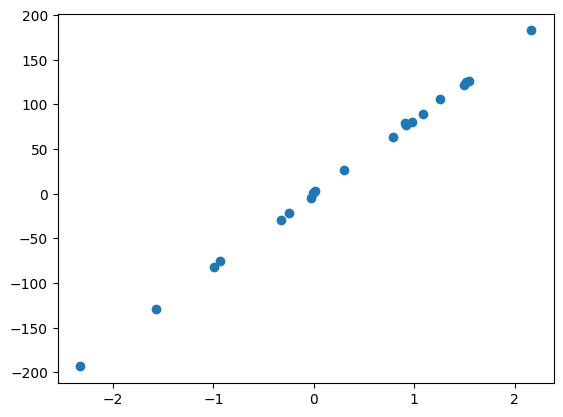

In [12]:
plt.scatter(X,y)

In [13]:
coef_tensor = torch.tensor(coef,dtype=torch.long)
coef_tensor

tensor(83)

In [14]:
first_set = Data(X,y,)

In [15]:
first_set.plot_container()


In [16]:
first_set.landscape(cost_fn=nn.MSELoss(),coef_1=coef_tensor)